In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import re

import random

from math import inf

import tqdm
from tqdm import tqdm

import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [104]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()
plt.figure(figsize=(14, 14))

<Figure size 1400x1400 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1400x1400 with 0 Axes>

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [106]:
class Dictionary():
    def __init__(self, name):
        self.name = name
        self.word2idx = {'<sos>': 0, '<eos>': 1, '<unk>': 2}
        self.word2count = {'<sos>': 1, '<eos>': 1, '<unk>': 1}
        self.idx2word = {0: '<sos>', 1: '<eos>', 2: '<unk>'}
        self.num_words = 3
        
    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWord(word)
        
    def addWord(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.num_words
            self.word2count[word] = 1
            self.idx2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    def __len__(self):
        return self.num_words

In [107]:
class Corpus():
    def __init__(self, source_name, target_name):
        self.source_lang = Dictionary(source_name)
        self.target_lang = Dictionary(target_name)
    
    def get_data(self, path, MAX_LENGTH=10):
        pairs = []

        with open(path, 'r') as lines:
            for line in lines:
                pair = line.replace('\n', '').split(',')
                if (len(pair[0].split()) <= MAX_LENGTH and 
                        len(pair[1].split()) <= MAX_LENGTH and 
                            len(pair[0].split()) > 2 and len(pair[1].split()) > 2):
                    pairs.append(pair)
                    self.source_lang.addSentence(pair[0])
                    self.target_lang.addSentence(pair[1])

        return pairs, self.source_lang, self.target_lang
    
corpus = Corpus('en', 'de')
MAX_LENGTH = 10
pairs, source_lang, target_lang = corpus.get_data('en-de_corpus.txt',
                                                  MAX_LENGTH=MAX_LENGTH)
random.choice(pairs)

['<sos> a solitary man is walking in a cemetery <eos>',
 '<sos> ein einsamer mann geht durch einen friedhof <eos>']

In [108]:
LEN_SOURCE_VOCAB = source_lang.num_words
LEN_TARGET_VOCAB = target_lang.num_words
LEN_SOURCE_VOCAB, LEN_TARGET_VOCAB

(3045, 3931)

In [109]:
print(f"Unique tokens in source (en) vocabulary: {LEN_SOURCE_VOCAB}")
print(f"Unique tokens in target (de) vocabulary: {LEN_TARGET_VOCAB}")

Unique tokens in source (en) vocabulary: 3045
Unique tokens in target (de) vocabulary: 3931


In [110]:
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
N_LAYERS = 1
DROPOUT = 0.5

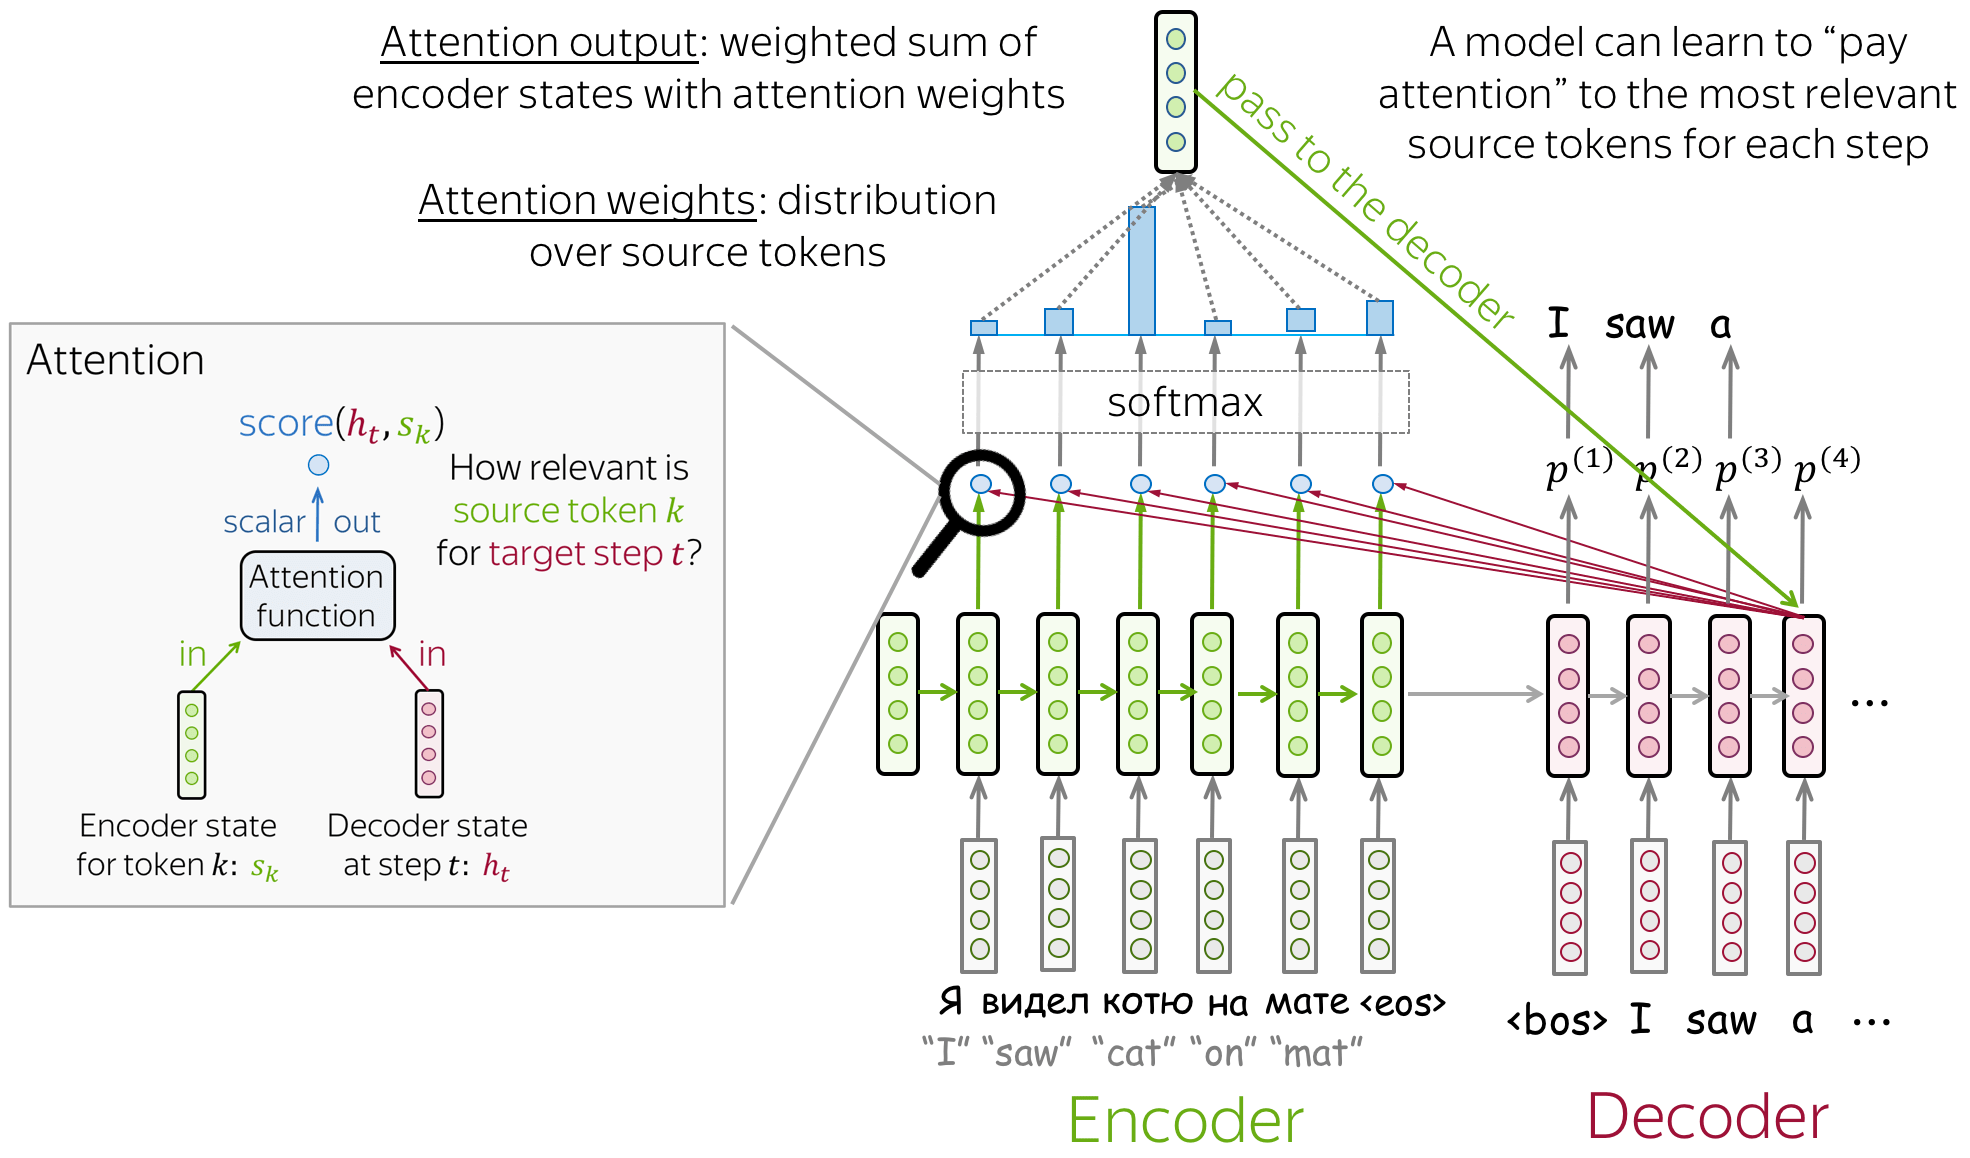

In [111]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, MAX_LENGTH, n_layers, dropout):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.MAX_LENGTH = MAX_LENGTH
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size,
                                      embedding_size)
        
        self.rnn = nn.GRU(embedding_size,
                           hidden_size,
                           n_layers,
                           dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, hidden):
        embed = self.dropout(self.embedding(source))
        
        output, hidden = self.rnn(embed, hidden)

        return output, hidden

encoder = Encoder(LEN_SOURCE_VOCAB,
                  EMBEDDING_SIZE,
                  HIDDEN_SIZE,
                  MAX_LENGTH,
                  N_LAYERS,
                  DROPOUT)

In [112]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_size, embedding_size, hidden_size, MAX_LENGTH, n_layers, dropout):
        super().__init__()

        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.MAX_LENGTH = MAX_LENGTH
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_size,
                                      embedding_size)
        
        self.attn = nn.Linear(self.embedding_size + self.hidden_size,
                                   self.MAX_LENGTH)
        self.attn_combine = nn.Linear(self.embedding_size + self.hidden_size,
                                   self.hidden_size)
        
        self.rnn = nn.GRU(embedding_size,
                           hidden_size,
                           n_layers,
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_size,
                             output_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
    
        embed = self.dropout(self.embedding(input))
        
        output, hidden = self.rnn(embed, hidden)

        attn_weights = F.softmax(
            self.attn(torch.cat((embed[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embed[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        prediction = self.fc1(output)

        return prediction, hidden, attn_weights

decoder = AttentionDecoder(LEN_TARGET_VOCAB,
                  EMBEDDING_SIZE,
                  HIDDEN_SIZE,
                  MAX_LENGTH,
                  N_LAYERS,
                  DROPOUT)

In [113]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        encoder_hidden = torch.zeros((self.encoder.n_layers, 1, self.encoder.hidden_size)).to(device)
        encoder_outputs = torch.zeros((encoder.MAX_LENGTH, self.encoder.hidden_size)).to(device)
  
        for ei in range(len(source)):
            encoder_output, encoder_hidden = self.encoder(source[ei].unsqueeze(1), 
                                          encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        target_word = target[0].unsqueeze(1)

        outputs = torch.zeros(len(target) - 1, self.decoder.output_size).to(device)

        decoder_hidden = encoder_hidden
        decoder_attentions = torch.zeros(encoder.MAX_LENGTH, encoder.MAX_LENGTH)

        for di in range(0, len(target) - 1):
            decoder_output, decoder_hidden, decoder_attention = self.decoder.forward(target_word, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data

            outputs[di] = decoder_output

            teacher_force = random.random() < teacher_forcing_ratio

            prediction = torch.tensor([decoder_output.argmax()]).to(device)

            target_word = target[di + 1].unsqueeze(1) if teacher_forcing_ratio else prediction.unsqueeze(1)

        return decoder_attentions, outputs

seq2seq = Seq2seq(encoder, decoder).to(device)

In [114]:
optimizer = optim.Adam(seq2seq.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [115]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.xavier_uniform_(param.data.unsqueeze_(0))
        
seq2seq.apply(init_weights)

Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(3045, 300)
    (rnn): GRU(300, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionDecoder(
    (embedding): Embedding(3931, 300)
    (attn): Linear(in_features=812, out_features=10, bias=True)
    (attn_combine): Linear(in_features=812, out_features=512, bias=True)
    (rnn): GRU(300, 512, dropout=0.5)
    (fc1): Linear(in_features=512, out_features=3931, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [116]:
def count_parameters(model):
    return sum(p.numel() for p in seq2seq.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 7,034,397 trainable parameters


In [117]:
def pair2tensor(pair):
    source = torch.tensor([source_lang.word2idx[word] for word in pair[0].split()], dtype=torch.long)
    target = torch.tensor([target_lang.word2idx[word] for word in pair[1].split()], dtype=torch.long)

    return source.unsqueeze(1), target.unsqueeze(1)

In [118]:
data_size = len(pairs)
data_size

4195

In [119]:
max_epoch = 25
best_epoch_loss = inf

epochs = []
losses = []

for epoch in range(1, max_epoch):
    seq2seq.train()

    epoch_loss = 0
    
    print('epoch:', epoch)

    for step, pair in enumerate(tqdm(pairs, file=sys.stdout)):
        source, target = pair2tensor(pair)
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()

        _, output = seq2seq.forward(source, target, teacher_forcing_ratio=0.5)

        loss = criterion(output, target[1:].squeeze())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()

    epochs.append(epoch)
    losses.append(epoch_loss / data_size)

    print('loss:', epoch_loss / data_size)

    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        torch.save(seq2seq.state_dict(), 'seq2seq_model.pt')

100%|██████████| 4195/4195 [01:31<00:00, 45.83it/s]
epoch: 1
loss: 4.780577203670474
100%|██████████| 4195/4195 [01:34<00:00, 44.60it/s]
epoch: 2
loss: 3.4661734536485533
100%|██████████| 4195/4195 [01:32<00:00, 45.49it/s]
epoch: 3
loss: 2.914210715905915
100%|██████████| 4195/4195 [01:31<00:00, 45.81it/s]
epoch: 4
loss: 2.5348582241732487
100%|██████████| 4195/4195 [01:31<00:00, 46.01it/s]
epoch: 5
loss: 2.233118452568826
100%|██████████| 4195/4195 [01:31<00:00, 46.08it/s]
epoch: 6
loss: 1.9790307951480577
100%|██████████| 4195/4195 [01:31<00:00, 46.07it/s]
epoch: 7
loss: 1.7476744986365547
100%|██████████| 4195/4195 [01:30<00:00, 46.11it/s]
epoch: 8
loss: 1.5495519139281586
100%|██████████| 4195/4195 [01:30<00:00, 46.43it/s]
epoch: 9
loss: 1.3512798075263035
100%|██████████| 4195/4195 [01:30<00:00, 46.33it/s]
epoch: 10
loss: 1.1496286807102167
100%|██████████| 4195/4195 [01:30<00:00, 46.40it/s]
epoch: 11
loss: 0.9959198404257565
100%|██████████| 4195/4195 [01:30<00:00, 46.57it/s]
epo

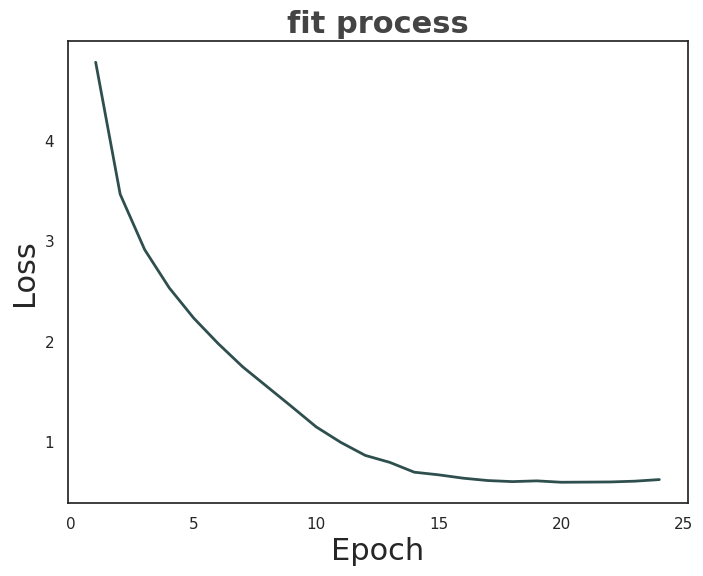

In [120]:
plt.plot(epochs, losses, color='darkslategray', linewidth=2)
plt.xlabel('Epoch', size=22)
plt.ylabel('Loss', size=22)
plt.title('fit process', size=22, y=1, 
          fontweight='bold', color='#444444')
plt.show()

In [121]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(input_sentence.split(' '), rotation=90)
    ax.set_yticklabels(output_words.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluate(model, num_samples):
    for sample in range(num_samples):
        seq2seq.eval()
        source_text, target_text = random.choice(pairs)
        print('>', source_text)
        print('=', target_text)
        source, target = pair2tensor([source_text, target_text])

        attentions, outputs = seq2seq.forward(source.to(device), target.to(device), 
                                teacher_forcing_ratio=0)
        
        plt.matshow(attentions.numpy())
        
        predicted = ' '.join([target_lang.idx2word[word.item()] 
                            for word in outputs.argmax(1)])
        
        showAttention(source_text, predicted, attentions)
        
        print('<', predicted)
        print('\n')

> <sos> a boy hangs onto straps on a train <eos>
= <sos> ein junge hangt an riemen an einem zug <eos>


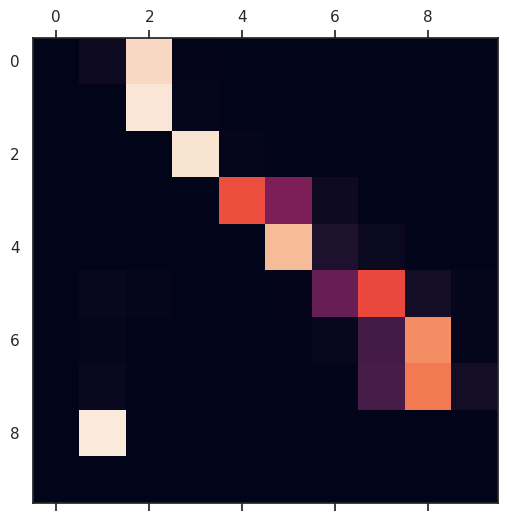

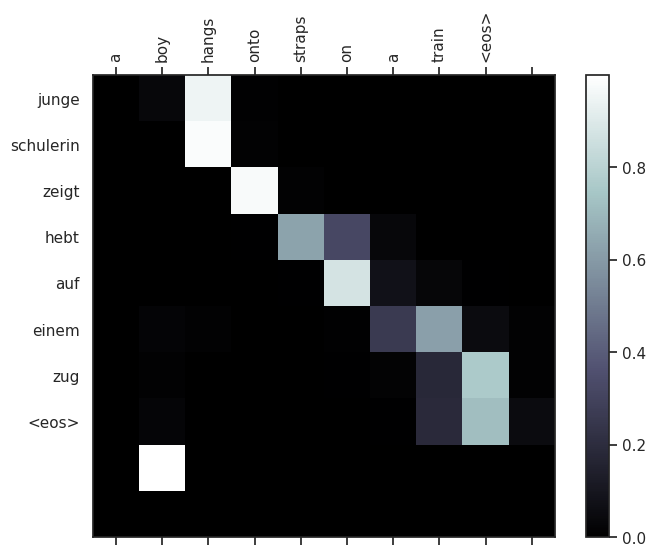

< ein junge schulerin zeigt hebt auf einem zug <eos>




In [140]:
evaluate(seq2seq, num_samples=1)

**resources**

https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

https://github.com/bentrevett/pytorch-seq2seq

https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAXtutorial6/Transformers_and_MHAttention.html
